In [1]:
with open("moliere_avare.txt", "r", encoding="utf-8") as f:
    texte = f.read()

print(texte[:500])  # affiche les 500 premiers caractères pour vérifier

---
identifier: moliere_avare  
creator: Molière.  
date: 1668  
title: L'Avare. Comédie  
---


L'AVARE,

COMÉDIE.

Par J.B.P. MOLIÈRE.

À PARIS, Chez JEAN RIBOU, au Palais, vis à vis la Porte de l'Église de la Sainte Chapelle, à l'Image Saint-Louis. M. DC. LXIX. *AVEC PRIVILÈGE DU ROI*



# ACTEURS.
 – Harpagon, Père de Cléante et d'Élise, et Amoureux de Mariane.
 – Cléante, Fils d'Harpagon, Amant de Mariane.
 – Élise, Fille d'Harpagon, Amante de Valère.
 – Valère, Fils d'Anselme, et Amant d'É


In [2]:
import re
import unicodedata
from collections import defaultdict, Counter

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (9, 5)

def strip_accents(s: str) -> str:
    return ''.join(c for c in unicodedata.normalize('NFD', s)
                   if unicodedata.category(c) != 'Mn')

def normalize_name(raw: str) -> str:
    s = raw.strip()
    s = s.replace('’', "'")
    s = s.replace('ſ', 's')  # vieilles ligatures éventuelles
    s = strip_accents(s).upper()
    s = re.sub(r'[^A-Z\- ]+', '', s)  # garde lettres/espaces/tirets
    s = re.sub(r'\s+', ' ', s).strip()
    return s

def word_count(text: str) -> int:
    # enlève didascalies [ ... ] ( ... ) et tirets de réplique
    text = re.sub(r'\[[^\]]*\]', ' ', text)
    text = re.sub(r'\([^)]*\)', ' ', text)
    text = text.replace('–', ' ')
    tokens = re.findall(r"[A-Za-zÀ-ÖØ-öø-ÿ']+", text)
    return len(tokens)

In [3]:
with open("moliere_avare.txt", "r", encoding="utf-8") as f:
    raw = f.read()

# normalisation minimale
raw = raw.replace('\r\n', '\n').replace('\r', '\n')

In [5]:
acte = "INCONNU"
scene = "INCONNUE"

# compte global par personnage
wc_by_char = Counter()

# compte par personnage ET par scène
wc_by_char_scene = defaultdict(int)

lines = raw.split('\n')
i = 0
while i < len(lines):
    line = lines[i].strip()

    # titres d'acte / scène (markdown)
    m_acte = re.match(r'^\s*##+\s*Acte\b\s*(.*)$', line, flags=re.I)
    m_scene = re.match(r'^\s*###+\s*Sc[eè]ne\b\s*(.*)$', line, flags=re.I)
    if m_acte:
        suffix = m_acte.group(1).strip()
        acte = f"ACTE {suffix or '?'}"
        i += 1
        continue
    if m_scene:
        suffix = m_scene.group(1).strip()
        scene = f"SCENE {suffix or '?'}"
        i += 1
        continue

    # ligne de locuteur (MAJUSCULES + point)
    m_speaker = re.match(r"^([A-ZÉÈÀÂÎÔÛÄËÏÖÜÇŒÆ'\- ]+)\.\s*$", line)
    if m_speaker:
        raw_name = m_speaker.group(1)
        name = normalize_name(raw_name)

        # récupérer la réplique (lignes suivantes jusqu'à ligne vide ou nouveau locuteur/titre)
        i += 1
        speech_lines = []
        while i < len(lines):
            nxt = lines[i]
            if not nxt.strip():
                break
            if re.match(r'^\s*##+', nxt):  # nouveau titre acte/scène
                break
            if re.match(r"^([A-ZÉÈÀÂÎÔÛÄËÏÖÜÇŒÆ'\- ]+)\.\s*$", nxt.strip()):
                break
            speech_lines.append(nxt)
            i += 1

        speech = "\n".join(speech_lines)
        n = word_count(speech)
        if n > 0:
            wc_by_char[name] += n
            key_scene = f"{acte} • {scene}"
            wc_by_char_scene[(name, key_scene)] += n
        continue

    i += 1

# DataFrames
df_total = pd.DataFrame(list(wc_by_char.items()), columns=["personnage", "mots"])\
             .sort_values("mots", ascending=False).reset_index(drop=True)

df_scene = pd.DataFrame(list(wc_by_char_scene.items()), columns=["pair", "mots"])
df_scene[["personnage", "scene"]] = pd.DataFrame(df_scene["pair"].tolist(), index=df_scene.index)
df_scene = df_scene.drop(columns=["pair"])

In [6]:
print(type(wc_by_char), len(wc_by_char))
print(list(wc_by_char.items())[:5])  # aperçu des 5 premiers

<class 'collections.Counter'> 13
[('VALERE', 2516), ('ELISE', 874), ('CLEANTE', 3120), ('HARPAGON', 5158), ('LA FLECHE', 1405)]


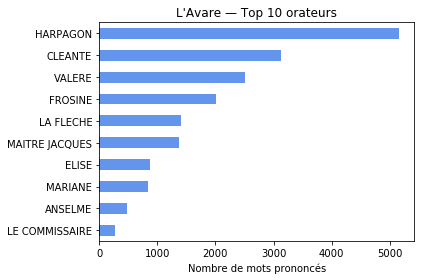

In [7]:
topN = 10  # nombre de personnages à afficher
ax = df_total.head(topN).iloc[::-1].plot(
    kind="barh",
    x="personnage",
    y="mots",
    color="cornflowerblue",
    legend=False
)
ax.set_xlabel("Nombre de mots prononcés")
ax.set_ylabel("")
ax.set_title(f"L'Avare — Top {topN} orateurs")
plt.tight_layout()
plt.savefig("avare_top_orateurs.png", dpi=150)
plt.show()

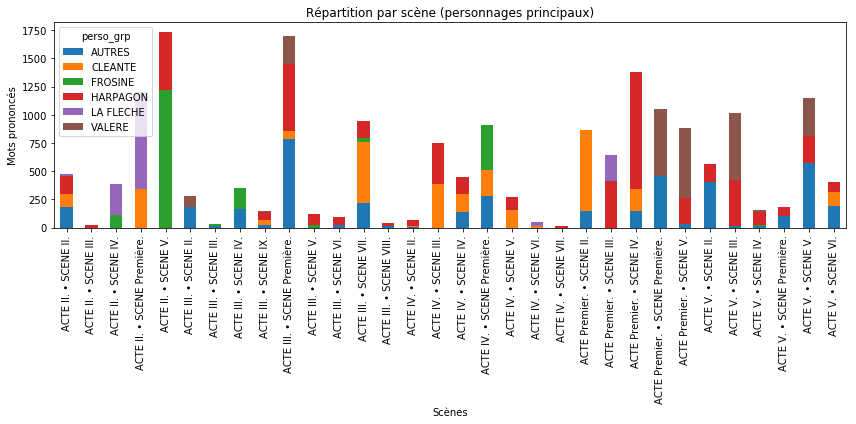

In [8]:
main_chars = set(df_total.head(5)["personnage"])
tmp = df_scene.copy()
tmp["perso_grp"] = np.where(tmp["personnage"].isin(main_chars), tmp["personnage"], "AUTRES")

pivot = tmp.pivot_table(index="scene", columns="perso_grp", values="mots", aggfunc="sum").fillna(0)
pivot = pivot.reindex(sorted(pivot.index), axis=0)

pivot.plot(kind="bar", stacked=True, figsize=(12,6))
plt.xlabel("Scènes")
plt.ylabel("Mots prononcés")
plt.title("Répartition par scène (personnages principaux)")
plt.tight_layout()
plt.savefig("avare_par_scene.png", dpi=150)
plt.show()

In [9]:
idx = df_scene.groupby("scene")["mots"].idxmax()
df_winner = df_scene.loc[idx, ["scene", "personnage", "mots"]].sort_values("scene")
df_winner.head(20)

scene      personnage  mots
14         ACTE II. • SCENE II.    MAITRE SIMON   180
19        ACTE II. • SCENE III.        HARPAGON    21
20         ACTE II. • SCENE IV.       LA FLECHE   274
13   ACTE II. • SCENE Première.       LA FLECHE   852
23          ACTE II. • SCENE V.         FROSINE  1223
32        ACTE III. • SCENE II.  MAITRE JACQUES   185
33       ACTE III. • SCENE III.         FROSINE    19
36        ACTE III. • SCENE IV.         FROSINE   183
50        ACTE III. • SCENE IX.        HARPAGON    74
25  ACTE III. • SCENE Première.  MAITRE JACQUES   737
37         ACTE III. • SCENE V.        HARPAGON   100
41        ACTE III. • SCENE VI.        HARPAGON    65
43       ACTE III. • SCENE VII.         CLEANTE   539
48      ACTE III. • SCENE VIII.        HARPAGON    21
57         ACTE IV. • SCENE II.        HARPAGON    52
61        ACTE IV. • SCENE III.         CLEANTE   386
63         ACTE IV. • SCENE IV.         CLEANTE   160
56   ACTE IV. • SCENE Première.         FROSINE   401
65          ACTE IV. • SCENE V.         CLEANTE   154
68         ACTE IV. • SCENE VI.       LA FLECHE    33

# Analyse des dialogues dans *L’Avare* de Molière

Ce document propose une exploration computationnelle du texte de *L’Avare*, en s’appuyant sur les données disponibles sur le site de l’OBVIL.
L’objectif est d’analyser la répartition de la parole entre les personnages — en particulier la quantité de mots prononcés, leur distribution selon les scènes, et la dynamique d’interlocution implicite.

Cette approche vise à relier **les structures littéraires visibles (le texte, les dialogues)** à des **structures invisibles** : rapports de pouvoir, densité psychologique des scènes, et hiérarchie dramatique implicite.

## Préparation des données

Le texte brut est issu du projet [OBVIL](https://obvil.sorbonne-universite.fr/corpus/moliere/l-avare/).
Nous avons téléchargé la version au format texte brut (.txt) et l’avons placée dans notre environnement Jupyter.
Chaque ligne contenant le nom d’un personnage suivi de ses répliques a été extraite à l’aide d’une expression régulière.

In [10]:
import re, pandas as pd, numpy as np, matplotlib.pyplot as plt
# (et tout ton parsing jusqu’à la création de df_total et df_scene)

## Résultats : distribution globale de la parole

Le premier graphique illustre la quantité totale de mots prononcés par chaque personnage dans l’ensemble de la pièce.
On observe que **Harpagon** domine nettement la parole, suivi de **Cléante** et de **Frosine**.  
Cette hiérarchie reflète déjà une logique dramatique : Harpagon, figure de l’avarice incarnée, occupe l’espace verbal comme il occupe l’espace matériel.

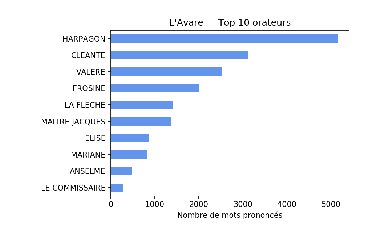

In [11]:
plt.imshow(plt.imread("avare_top_orateurs.png"))
plt.axis("off")
plt.show()

## Répartition par scène

Le graphique suivant montre, pour chaque scène, la proportion de mots prononcés par les personnages principaux.  
Cette visualisation permet de détecter les bascules de tension : certaines scènes sont dominées par Frosine, d’autres par Cléante ou Élise, révélant la mécanique d’équilibre typique de Molière.

On perçoit aussi une alternance rythmique : la parole circule comme un bien disputé — signe que, chez Molière, **le langage lui-même devient monnaie d’échange**.

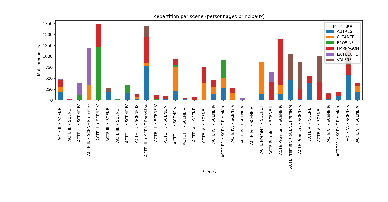

In [12]:
plt.imshow(plt.imread("avare_par_scene.png"))
plt.axis("off")
plt.show()

## Interprétation synthétique

L’analyse computationnelle des dialogues de *L’Avare* révèle un ordre latent : celui de la parole comme capital symbolique.
Plus un personnage parle, plus il contrôle la scène ; mais certains, comme Frosine, dominent sans posséder le pouvoir matériel, tandis que d’autres, comme Élise, sont souvent présents par le silence.
Ce contraste entre parole et pouvoir forme la véritable tension du texte.

Ainsi, derrière l’économie de l’argent se joue une **économie du verbe** — où parler, c’est dépenser, et se taire, c’est accumuler.
